# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [2]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

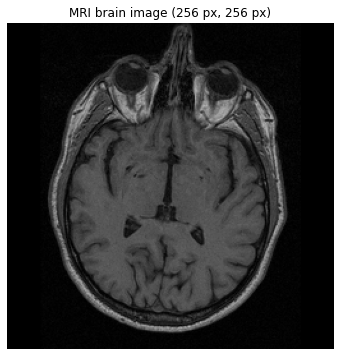

In [3]:
import skimage.io
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
def display_img(brain_im, rec=None):
    fig, ax = plt.subplots(1, len(brain_im), figsize=(6*len(brain_im), 6))
    if len(brain_im) > 1:
        for i in range(len(ax)):
            ax[i].imshow(brain_im[i], cmap='gray', vmin=0, vmax=255)
            ax[i].set_title('MRI brain image ({} px, {} px)'.format(*brain_im[i].shape))
            ax[i].axis('off')
            if ((rec != None) and (len(rec) > i)):
                start = rec[i][0]
                width = rec[i][1]
                height = rec[i][2]
                rect = patches.Rectangle(start, width, height, linewidth=2, edgecolor='r', facecolor='none')
                ax[i].add_patch(rect)
            if rec and i == len(rec):
                w = np.random.randint(low=0, high=brain_im[i].shape[0] - 10)
                h = np.random.randint(low=0, high=brain_im[i].shape[1] - 10)
                ax[i].plot(w, h, c='white', marker='*', markersize=15)
                ax[i].annotate(f'({w + 135}, {h + 125})', (w + 2, h + 2), fontsize=25, color='white')
    else:
        if rec:
            print('Hov! Vous ne pouver pas utiliser "rectangles" avec seulement un plot')
        ax.imshow(brain_im[0], cmap='gray', vmin=0, vmax=255)
        ax.set_title('MRI brain image ({} px, {} px)'.format(*brain_im[0].shape))
        ax.axis('off')        
    plt.show()
    
def hist_values(region):
    if len(region.shape) > 1:
        region = region.ravel()
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))
    ax.hist(region)
    ax.axvline(min(region), c='r', ls='--')
    ax.axvline(max(region), c='r', ls='--')
    ax.annotate(f'min = {min(region)}', (min(region) + 0.7, 100), rotation='vertical', fontsize=20)
    ax.annotate(f'max = {max(region)}', (max(region) - 1.5, 100), rotation='vertical', fontsize=20)
    plt.show()
    

display_img((brain_im,))

### 1.2 Region growing (5pts)

For region growing, we need (a) a start point and (b) a treshold. We'll start by finding a suitable starting point. In the plots, we progressively zoom in on one area that we are "sure" is brain matter. We can choose a point at random from this square as our starting point.

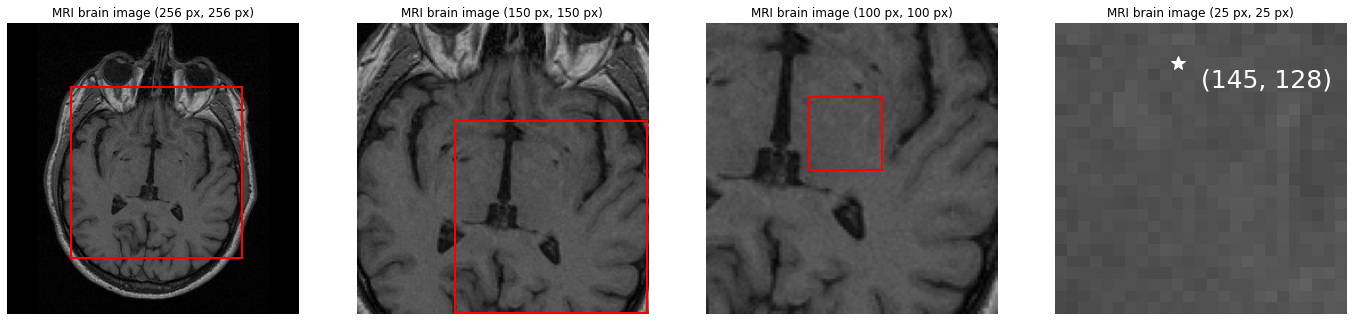

In [4]:
import numpy as np
import matplotlib.patches as patches

crops = [[0, 256, 0, 256], [50, 200, 50, 200], [100, 200, 100, 200], [125, 150, 135, 160]]
rec = [[(56, 56), 150, 150], [(50, 50), 99, 99], [(35, 25), 25, 25]]
brain_ims = [brain_im[a:b, c:d] for (a, b, c, d) in crops]
display_img(brain_ims, rec)

The point at (139, 134) has the following color intensity 77 (found by indexing the array at the coordinate). The histogram of values in the region we believe is brain matter (the right-most plot above) is shown below. We see that the minimum value is 68 and the maximum value is 97.

77


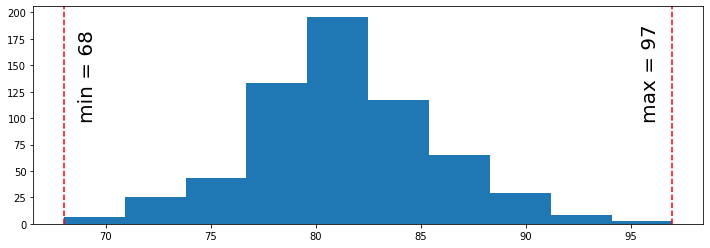

In [5]:
print(brain_im[139, 134])
hist_values(brain_im[125:150, 135:160].ravel())

Let's use these as our threshold values, to start with.

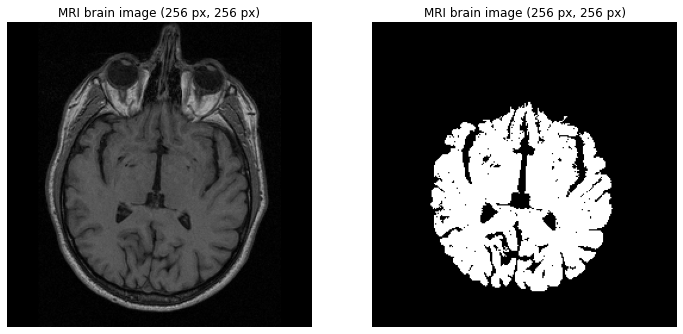

In [7]:
seed = (139, 138)
result = np.zeros_like(brain_im)
upper_threshold = 95
lower_threshold = 60
queue = [seed]
result[seed] = 255

f = np.vectorize(lambda x: 1 if (x <= upper_threshold and x >= lower_threshold) else 0)
watermap = f(brain_im)

while len(queue) > 0:
    x, y = queue.pop(0)    
    coordinates = [(x - 1, y - 1), (x, y - 1), (x + 1, y - 1),
                   (x - 1, y),                 (x + 1, y),
                   (x - 1, y + 1), (x, y + 1), (x + 1, y + 1)]
    for x_, y_ in coordinates:
        if not result[x_, y_] and watermap[x_, y_]:
            result[x_, y_] = 255
            queue += [(x_, y_)]

display_img((brain_im, result))

We seem to have segmented the soft tissue in the brain. Let's clean up the resulting image using an opening. The structuring element seen in the code below was found using trial and error. To implement the opening, we use the $\texttt{morphology.opening}$ function from scikit's image processing library (see https://bit.ly/3KTIwA7 for documentation). 

The original and the cleaned segmentations are shown below on the left and right, respectively. In the cleaned segmentation, we can see the shape of the brain a bit more clearly, however, we of course lose some details along the edges. Additionally, not all internal holes in the brain tissue seem to have been patched.

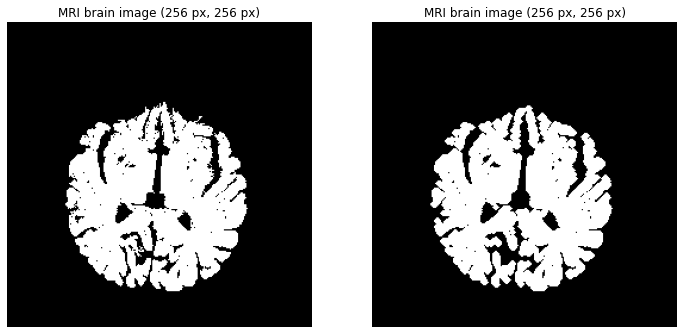

In [195]:
import skimage.morphology as m

struct_elem = np.array([[0,0,1,1,0,0],
                        [0,1,1,1,1,0],
                        [1,1,1,1,1,1],
                        [0,1,1,1,1,0],
                        [0,0,1,1,0,0]])
display_img((result, m.opening(result, struct_elem)))

The total number of pixels in the cleaned segmentation is given below:

In [10]:
print(f'The total number of pixels is: {(result // 255).sum()}.')

The total number of pixels is: 15354.


### 1.3 Contour detection (5pts)

In [11]:
# Add your implementation and discussion

### 1.4 Additional method (5pts)

In [12]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [252]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


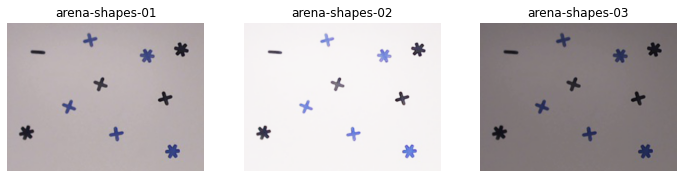

In [258]:
# Plot images
def plot_im(images, figtitle=None):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, im, nm in zip(axes.ravel(), images, im_names):
        ax.imshow(im)
        ax.axis('off')
        ax.set_title(nm)
    fig.suptitle(figtitle, fontsize=20)
    plt.show()
plot_im(images)

### 2.2 Number of shapes of each color (5 pts)

We start by correcting the illumination of the images. To do so, we try to shift the histogram of images 1 and 3 to match the historgram of image 2. We do this using the $\texttt{exposure.match_histograms}$ function from skimages. The result is plotted below:

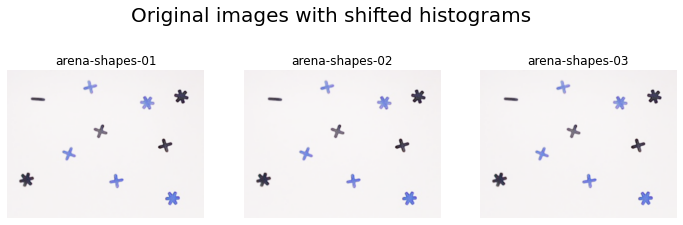

In [260]:
import skimage.color as c
import skimage.exposure as e
import skimage.measure as meas

newimages = np.array([
    e.match_histograms(images[0], images[1], channel_axis=-1),
    images[1],
    e.match_histograms(images[2], images[1], channel_axis=-1)
])

plot_im(newimages, 'Original images with shifted histograms')

Next, we shift the color

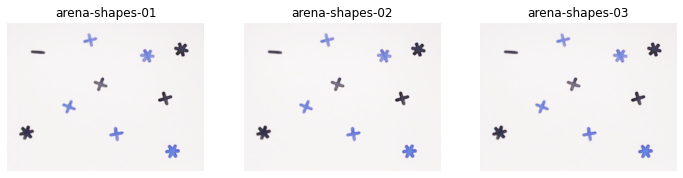

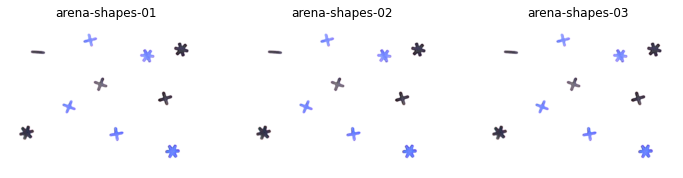

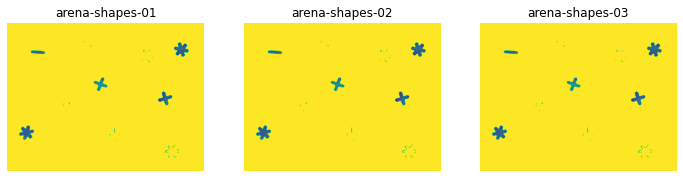

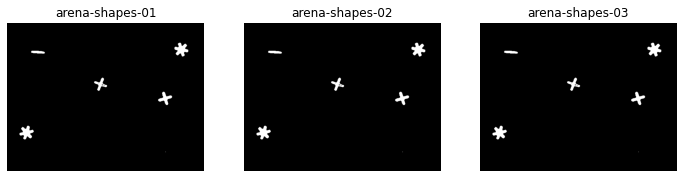

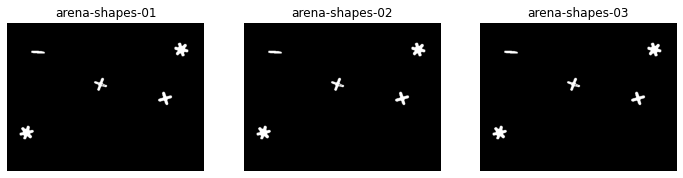

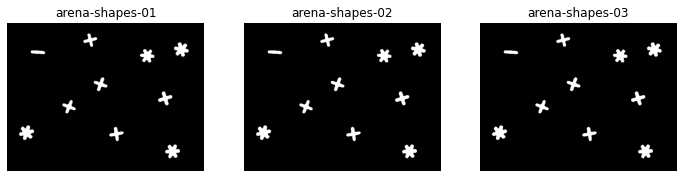

The number of black shapes in image 0 is 5
The number of light blue shapes in image 0 is 5
The number of black shapes in image 1 is 5
The number of light blue shapes in image 1 is 5
The number of black shapes in image 2 is 5
The number of light blue shapes in image 2 is 5


In [250]:
import skimage.color as c
import skimage.exposure as e
import skimage.measure as meas

newimages = np.array([
    e.match_histograms(images[0], images[1], channel_axis=-1),
    images[1],
    e.match_histograms(images[2], images[1], channel_axis=-1)
])

# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), newimages, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
newimages = np.array([np.where(im < 200, im, 255) for im in newimages])
for ax, im, nm in zip(axes.ravel(), newimages, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 12))
newimages_v = np.array([c.rgb2hsv(im)[:,:,2] for im in newimages])
for ax, im, nm in zip(axes.ravel(), newimages_v, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(12, 12))
darkshapes = np.array([np.where(im < 0.55, 255, 0) for im in newimages_v])
for ax, im, nm in zip(axes.ravel(), darkshapes, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

darkshapes = np.array([m.opening(im, np.ones((3,3))) for im in darkshapes])
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), darkshapes, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

allshapes = np.array([m.opening(np.where(c.rgb2gray(im) < 1, 255, 0), np.ones((3,3))) for im in newimages])
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), allshapes, im_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
plt.show()

for i, im, ima in zip(range(3), darkshapes, allshapes):
    nshape = meas.label(ima, return_num=True)[1]
    ndark = meas.label(im, return_num=True)[1]
    print(f'The number of black shapes in image {i} is {ndark}')
    print(f'The number of light blue shapes in image {i} is {nshape - ndark}')


### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion